# Predicting Household Energy Usage

### Hunter Adrian  
### Brown University  
### [GitHub Repository Link](https://github.com/huntera-1/Data1030-Final-Project)  
### December 15, 2024

## Load Data

In [122]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore') 

In [123]:
# Load the dataset
data_path = "../data/energy_data.csv"
df = pd.read_csv(data_path)

# Convert 'date' column to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

## Rename Variables add Features

In [124]:
# Rename columns for clarity
rename_dict = {
    'Appliances': 'Energy_Consumption',
    'lights': 'Lights',
    'T1': 'Kitchen_Temp', 'RH_1': 'Kitchen_Humid',
    'T2': 'Living_Temp', 'RH_2': 'Living_Humid',
    'T3': 'Laundry_Temp', 'RH_3': 'Laundry_Humid',
    'T4': 'Office_Temp', 'RH_4': 'Office_Humid',
    'T5': 'Bath_Temp', 'RH_5': 'Bath_Humid',
    'T6': 'Outdoor_North_Temp', 'RH_6': 'Outdoor_North_Humid',
    'T7': 'Ironing_Temp', 'RH_7': 'Ironing_Humid',
    'T8': 'Teen_Room_Temp', 'RH_8': 'Teen_Room_Humid',
    'T9': 'Parents_Room_Temp', 'RH_9': 'Parents_Room_Humid',
    'T_out': 'Outdoor_Temp', 'RH_out': 'Outdoor_Humid',
    'Press_mm_hg': 'Pressure', 'Windspeed': 'Wind_Speed',
    'Visibility': 'Visibility', 'Tdewpoint': 'Dew_Point',
    'rv1': 'Rand_Var_1', 'rv2': 'Rand_Var_2'
}
df.rename(columns=rename_dict, inplace=True)

# Splitting Data

In [125]:
# Split into train, validation, and test sets before feature engineering (60/20/20)
train_size = int(len(df) * 0.6)
validation_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_validation = df.iloc[train_size:validation_size]
df_test = df.iloc[validation_size:]

print(f"Training set: {df_train.shape[0]} samples")
print(f"Validation set: {df_validation.shape[0]} samples")
print(f"Test set: {df_test.shape[0]} samples")


Training set: 11841 samples
Validation set: 3947 samples
Test set: 3947 samples


In [126]:
def engineer_features(data):
    # Feature engineering
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek

    # Cyclical encoding for hour and day_of_week
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

    # Add lag and rolling features
    data['lag_1'] = data['Energy_Consumption'].shift(1)
    data['lag_3'] = data['Energy_Consumption'].shift(3)
    data['lag_6'] = data['Energy_Consumption'].shift(6)
    data['rolling_mean_3'] = data['Energy_Consumption'].rolling(window=3).mean()
    data['rolling_std_3'] = data['Energy_Consumption'].rolling(window=3).std()
    data['rolling_mean_6'] = data['Energy_Consumption'].rolling(window=6).mean()
    data['rolling_std_6'] = data['Energy_Consumption'].rolling(window=6).std()

    # Drop NaN values after creating lag and rolling features
    data.dropna(inplace=True)
    return data

In [127]:
df_train = engineer_features(df_train)
df_validation = engineer_features(df_validation)
df_test = engineer_features(df_test)

# Define target (y) and features (X) for each split
y_train = df_train['Energy_Consumption']
X_train = df_train.drop(columns=['Energy_Consumption'])

y_validation = df_validation['Energy_Consumption']
X_validation = df_validation.drop(columns=['Energy_Consumption'])

y_test = df_test['Energy_Consumption']
X_test = df_test.drop(columns=['Energy_Consumption'])

# Print dataset sizes
print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_validation.shape}, y={y_validation.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Training set: X=(11835, 43), y=(11835,)
Validation set: X=(3941, 43), y=(3941,)
Test set: X=(3941, 43), y=(3941,)


## EDA Visuals

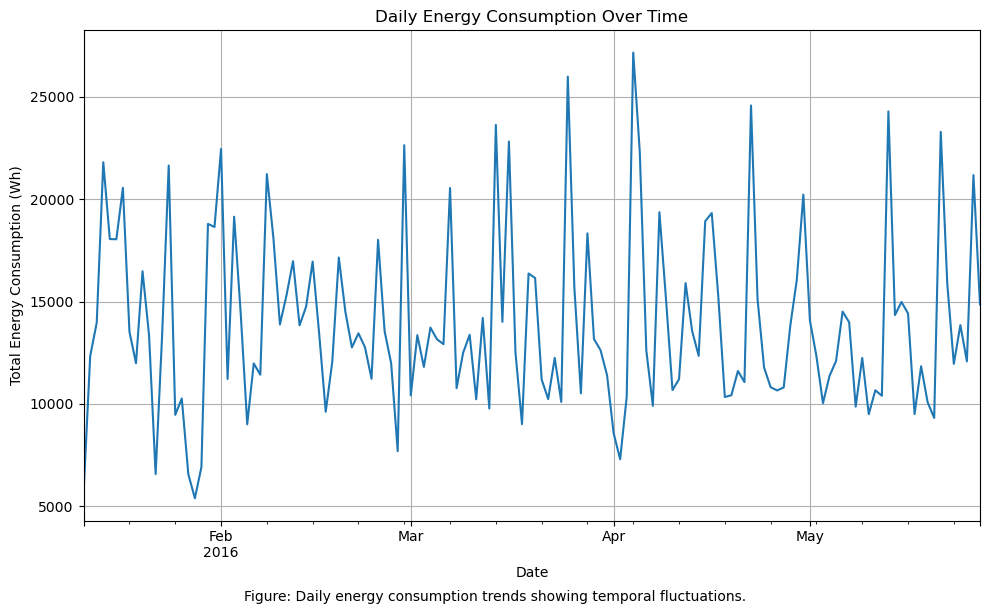

In [128]:
plt.figure(figsize=(10, 6))
df.resample('D')['Energy_Consumption'].sum().plot()
plt.title('Daily Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumption (Wh)')
plt.grid(True)
plt.tight_layout()
plt.figtext(0.5, -0.01, 'Figure: Daily energy consumption trends showing temporal fluctuations.', ha='center', fontsize=10)
plt.savefig('../figures/energy_consumption_trends.png', bbox_inches='tight', dpi=300)
plt.show()


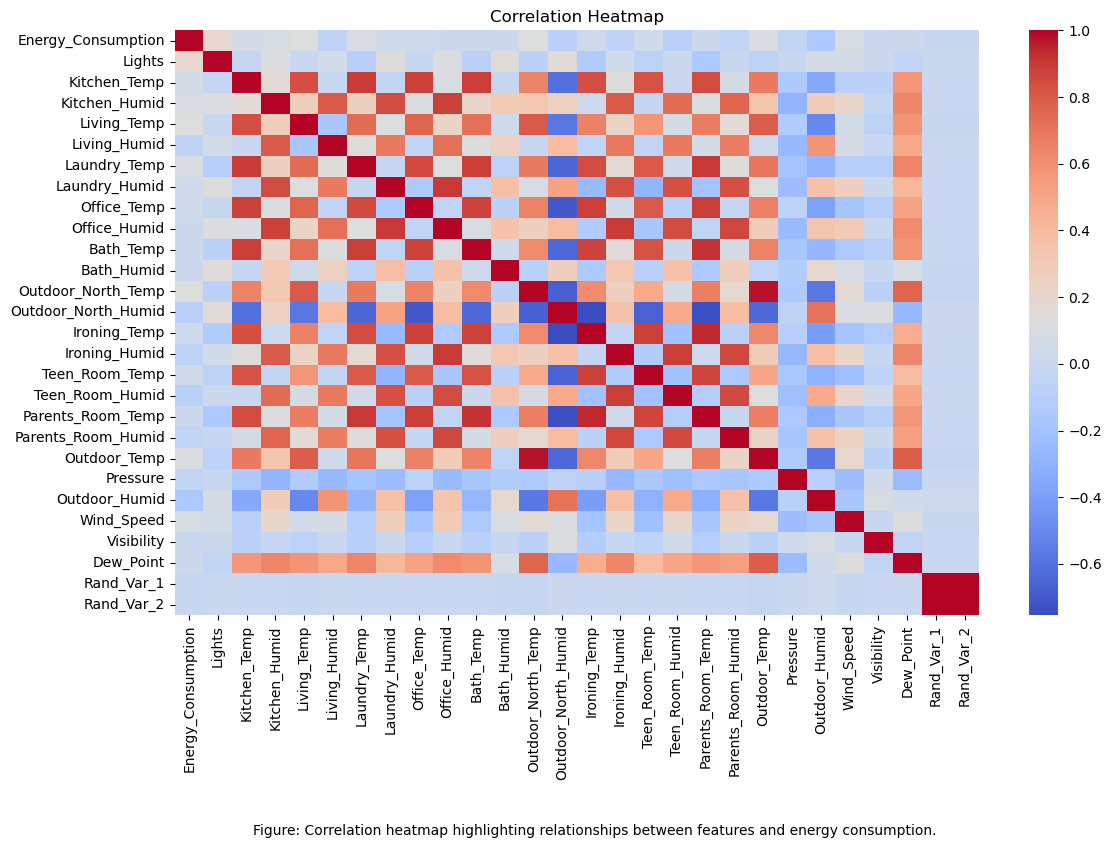

In [129]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.figtext(0.5, -0.05, 'Figure: Correlation heatmap highlighting relationships between features and energy consumption.', ha='center', fontsize=10)
plt.savefig('../figures/correlation_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()


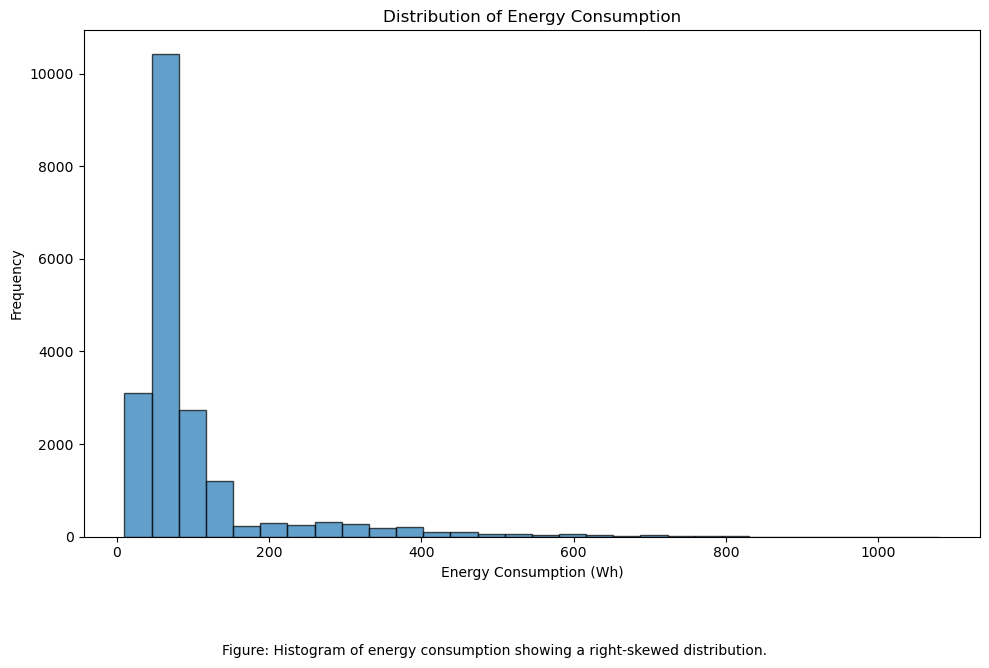

In [130]:
plt.figure(figsize=(10, 6))
df['Energy_Consumption'].plot(kind='hist', bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.figtext(0.5, -0.1, 'Figure: Histogram of energy consumption showing a right-skewed distribution.', ha='center', fontsize=10)
plt.savefig('../figures/histogram_energy_distribution.png', bbox_inches='tight', dpi=300)
plt.show()


# Preprocessing

In [131]:
# Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge_model', Ridge())
])
ridge_hyperparameters = {'ridge_model__alpha': uniform(0.1, 300)}

# Random Forest Pipeline
random_forest_pipeline = Pipeline([
    ('random_forest_model', RandomForestRegressor(random_state=42))
])
random_forest_hyperparameters = {
    'random_forest_model__n_estimators': [50, 100, 200],
    'random_forest_model__max_depth': [10, 20, 50, None]
}

# XGBoost Model
xgboost_pipeline = Pipeline([
    ('model', XGBRegressor(random_state=42, eval_metric='rmse'))
])
xgboost_hyperparameters = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 6, 9]
}

In [132]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)
print(f"Time series cross-validation with {tscv.get_n_splits()} splits.")

Time series cross-validation with 3 splits.


In [133]:
def tune_model(model, param_grid, model_name, X_train, y_train):
    print(f"\nTuning {model_name}...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring='neg_root_mean_squared_error',
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    search.fit(X_train, y_train)
    print(f"{model_name} Best Params: {search.best_params_}")
    print(f"{model_name} Best CV RMSE: {-search.best_score_:.4f}")
    return search.best_estimator_


In [134]:
# Tune Ridge Regression
ridge_best = tune_model(ridge_pipeline, ridge_hyperparameters, "Ridge Regression", X_train, y_train)

# Tune Random Forest
rf_best = tune_model(random_forest_pipeline, random_forest_hyperparameters, "Random Forest", X_train, y_train)

# Tune XGBoost
xgb_best = tune_model(xgboost_pipeline, xgboost_hyperparameters, "XGBoost", X_train, y_train)

print("\nModel tuning completed.")


Tuning Ridge Regression...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Ridge Regression Best Params: {'ridge_model__alpha': 19.615477895583858}
Ridge Regression Best CV RMSE: 43.1295

Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest Best Params: {'random_forest_model__n_estimators': 200, 'random_forest_model__max_depth': 50}
Random Forest Best CV RMSE: 38.1613

Tuning XGBoost...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
XGBoost Best Params: {'model__max_depth': 3, 'model__learning_rate': 0.1}
XGBoost Best CV RMSE: 38.2377

Model tuning completed.


In [135]:
# Evaluation function
def evaluate_model(model, X, y, model_name):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    print(f"{model_name} Test RMSE: {rmse:.4f}")
    print(f"{model_name} Test R²: {r2:.4f}")
    return rmse, r2


print("\nEvaluating models on the test set:")
# Baseline RMSE: Mean prediction for the entire test set
baseline_rmse = np.sqrt(mean_squared_error(y_test, [y_test.mean()] * len(y_test)))
print(f"Baseline RMSE: {baseline_rmse:.4f}")
ridge_rmse, ridge_r2 = evaluate_model(ridge_best, X_test, y_test, "Ridge Regression")
rf_rmse, rf_r2 = evaluate_model(rf_best, X_test, y_test, "Random Forest")
xgb_rmse, xgb_r2 = evaluate_model(xgb_best, X_test, y_test, "XGBoost")


Evaluating models on the test set:
Baseline RMSE: 90.4786
Ridge Regression Test RMSE: 41.2233
Ridge Regression Test R²: 0.7924
Random Forest Test RMSE: 40.0705
Random Forest Test R²: 0.8039
XGBoost Test RMSE: 39.9949
XGBoost Test R²: 0.8046


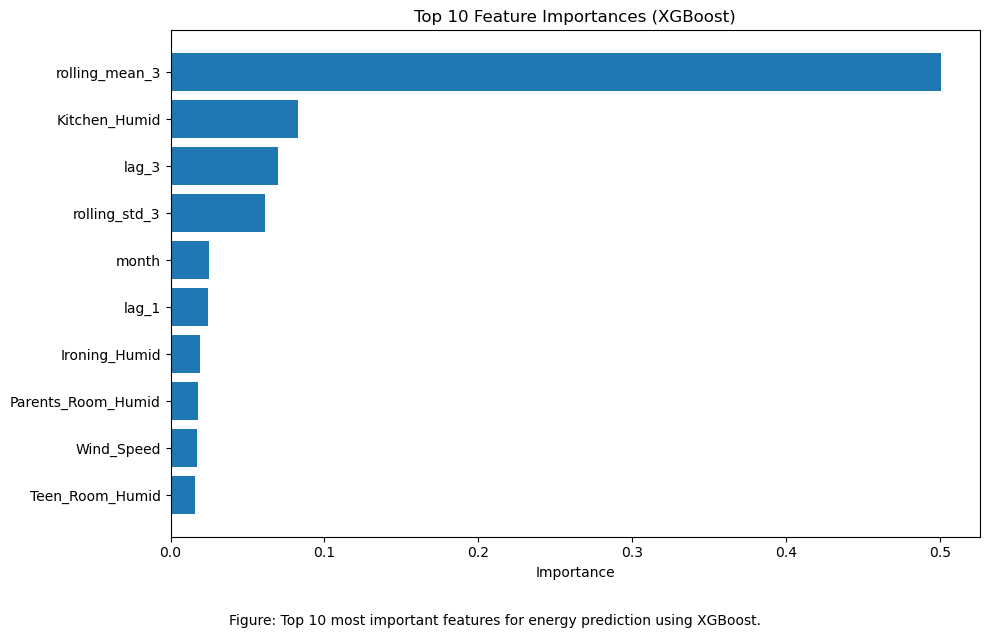

In [136]:
# Feature importance for XGBoost
importances = xgb_best.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1][:10]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices][::-1], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.tight_layout()
plt.figtext(0.5, -0.05, 'Figure: Top 10 most important features for energy prediction using XGBoost.', ha='center', fontsize=10)
plt.savefig('../figures/xgboost_feature_importance.png', dpi=300)
plt.show()


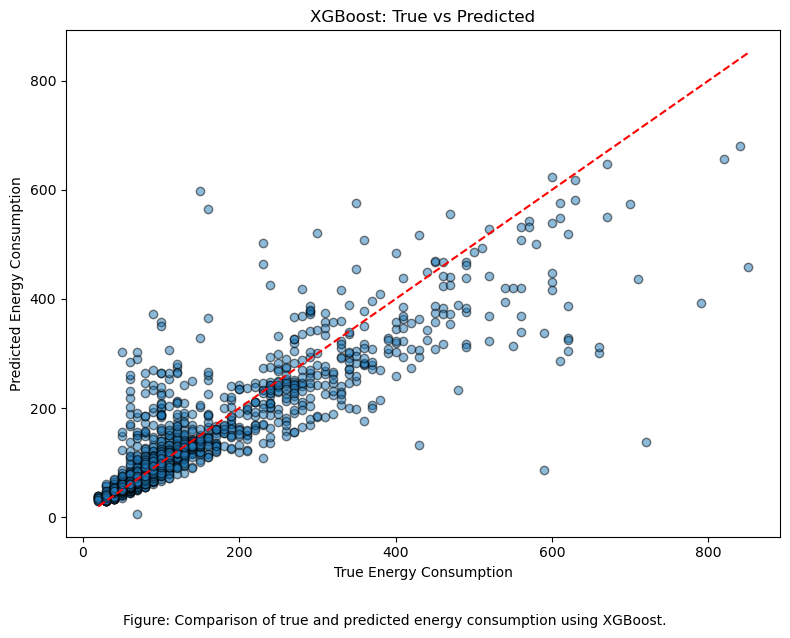

In [137]:
# True vs Predicted Plot for XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_best.predict(X_test), alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("XGBoost: True vs Predicted")
plt.tight_layout()
plt.figtext(0.5, -0.05, 'Figure: Comparison of true and predicted energy consumption using XGBoost.', ha='center', fontsize=10)
plt.savefig('../figures/xgboost_true_vs_predicted.png', dpi=300)
plt.show()


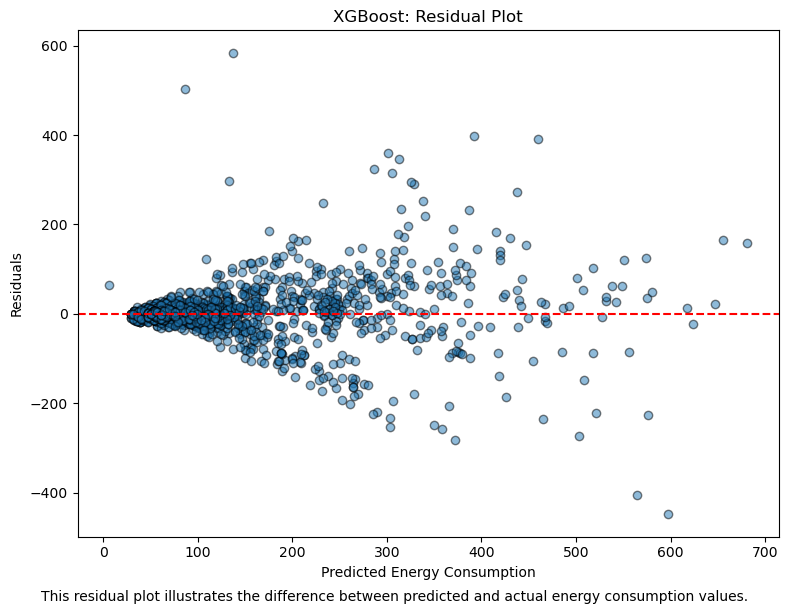

In [138]:
# Residual Plot for XGBoost
residuals = y_test - xgb_best.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(xgb_best.predict(X_test), residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Energy Consumption")
plt.ylabel("Residuals")
plt.title("XGBoost: Residual Plot")
plt.figtext(
    0.5, -0.01, 
    "This residual plot illustrates the difference between predicted and actual energy consumption values.", ha="center", fontsize=10
)
plt.tight_layout()
plt.savefig("../figures/xgboost_residual_plot.png", dpi=300)
plt.show()
plt.close()


In [139]:
import joblib

# Save the best models
joblib.dump(ridge_best, "../results/ridge_best_model.joblib")
joblib.dump(rf_best, "../results/random_forest_best_model.joblib")
joblib.dump(xgb_best, "../results/xgboost_best_model.joblib")

print("Best models saved successfully in the 'results' directory.")

Best models saved successfully in the 'results' directory.
